## Text Mining:

Text mining, also referred to as text data mining, roughly equivalent to text analytics, is the process of deriving high-quality information from text. High-quality information is typically derived through the devising of patterns and trends through means such as statistical pattern learning. Text mining usually involves the process of structuring the input text (usually parsing, along with the addition of some derived linguistic features and the removal of others, and subsequent insertion into a database), deriving patterns within the structured data, and finally evaluation and interpretation of the output. 'High quality' in text mining usually refers to some combination of relevance, novelty, and interestingness. Typical text mining tasks include text categorization, text clustering, concept/entity extraction, production of granular taxonomies, sentiment analysis, document summarization, and entity relation modeling (i.e., learning relations between named entities).

Text analysis involves information retrieval, lexical analysis to study word frequency distributions, pattern recognition, tagging/annotation, information extraction, data mining techniques including link and association analysis, visualization, and predictive analytics. The overarching goal is, essentially, to turn text into data for analysis, via application of natural language processing (NLP) and analytical methods.

A typical application is to scan a set of documents written in a natural language and either model the document set for predictive classification purposes or populate a database or search index with the information extracted.

In the previous notebook we have done some Exploratory Data Analysis of various variables including:                  
- item_condition_id      
- category_name        
- brand_name            
- price                
- shipping               
- item_description     
present in the dataset to see thier relationship with the target (price) variable. 


In this notebook I am going to do use text mining to further explore the features and then segregate various products using 
- LDA 
- K-means Clustering

The following section is based on the tutorial at https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html




## Imports

In [38]:
# for data manipulations
import pandas as pd
import numpy as np

# for dealing with string
import re
import string
import nltk


# for plotting 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= 'white')

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.transform import  factor_cmap
from bokeh.plotting import figure, show, output_notebook

# for textminig 
from nltk.stem.porter import  *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# for handling warning
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('lda').setLevel(logging.WARNING)



In [5]:
# loading the datasets
train = pd.read_pickle('./pickle/train.pkl')
test = pd.read_pickle('./pickle/test.pkl')

## Text Processing - Item Description

### Pre-processing: tokenization
Most of the time, the first steps of an NLP project is to "tokenize" your documents, which main purpose is to normalize our texts. The three fundamental stages will usually include:

- break the descriptions into sentences and then break the sentences into tokens
- remove punctuation and stop words
- lowercase the tokens
- herein, I will also only consider words that have length equal to or greater than 3 characters (3- grams)



In [39]:
stop_words = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segments text into sentences
    word_tokenize(): breaks sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: 
        return 0
        

In [7]:
# # apply the tokenizer into the item descriptipn column
# train['tokens'] = train['item_description'].map(tokenize)
# test['tokens'] = test['item_description'].map(tokenize)

In [9]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len,tokens
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1,"[description, yet]"
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14,"[keyboard, great, condition, works, like, came..."
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8,"[adorable, top, hint, lace, key, hole, back, p..."
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14,"[new, tags, leather, horses, retail, stand, fo..."
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3,"[complete, certificate, authenticity]"


In [3]:
# # exporting the train data into pickle that can be loaded later.
# train.to_pickle('./pickle/train_token.pkl')
# test.to_pickle('./pickle/test_token.pkl')

# train = pd.read_pickle('./pickle/train_token.pkl')
# test = pd.read_pickle('./pickle/test_token.pkl')

In [11]:
# lets look at some descriptions along with its tokens
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

description: No description yet
tokens: ['description', 'yet']

description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app']

description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']

description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 

In [46]:
# lets see the most common occuring words in each categories
general_cats = train['general_cat'].value_counts().head(5).index.values.astype('str')
general_cats

array(['Women', 'Beauty', 'Kids', 'Electronics', 'Men'], dtype='<U11')

In [47]:
# building a dict with key = category and value = all the descriptions for that category
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)


In [49]:
# cat_desc

In [50]:
# find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)


In [51]:
# plot word cloud
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

Text(0.5,1,'Electronic Top 100')

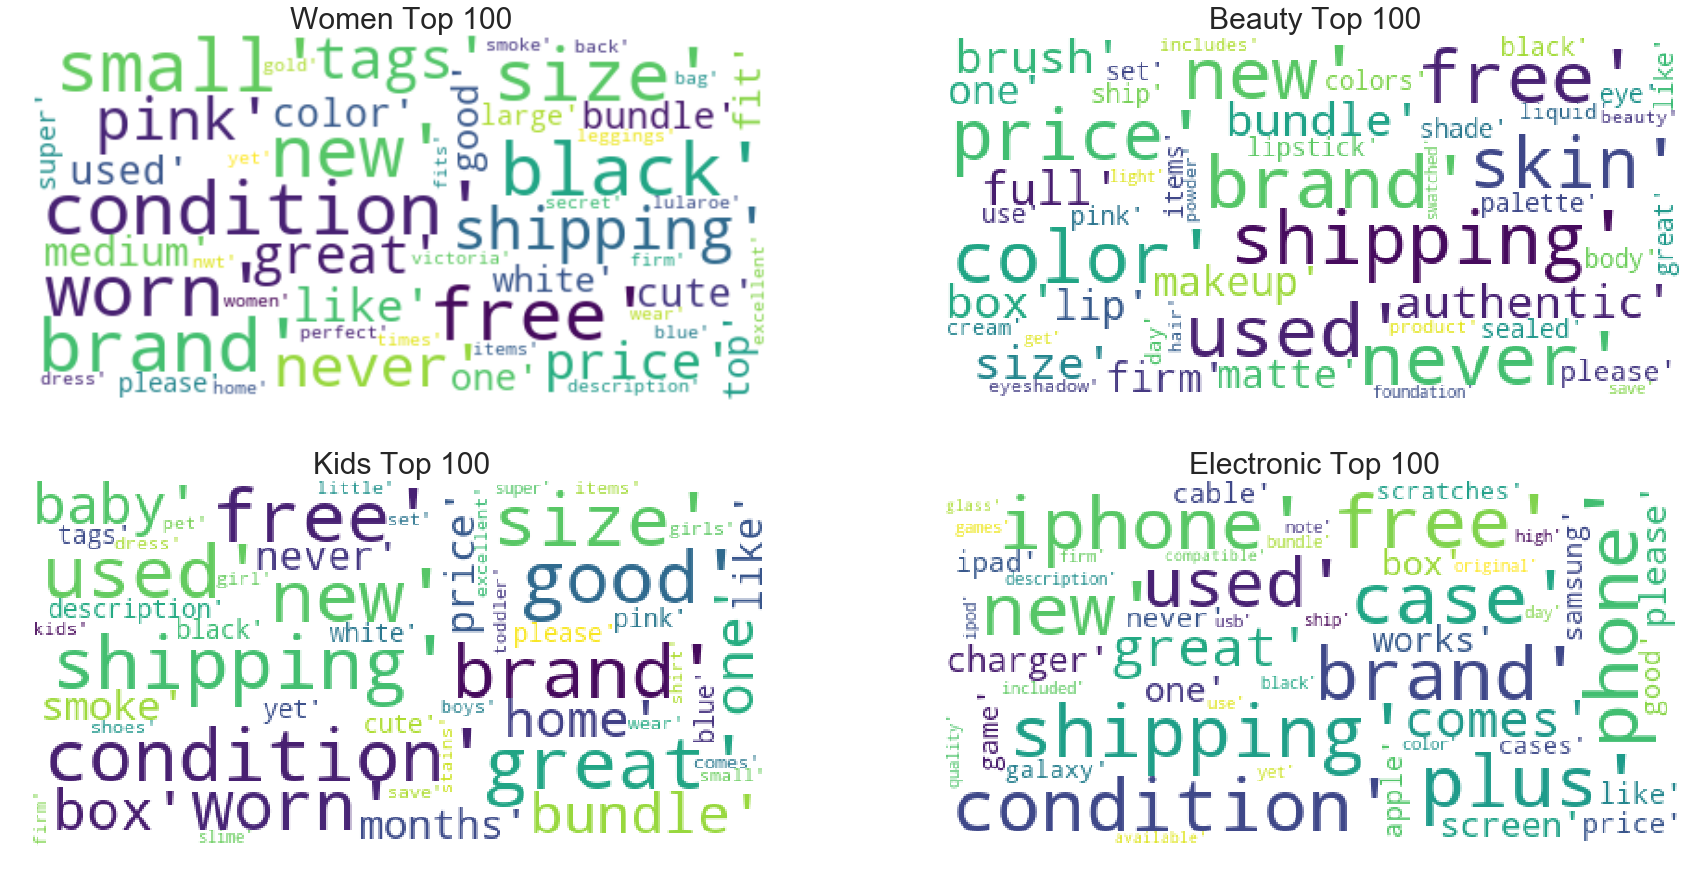

In [100]:
fig,axes = plt.subplots(2, 2, figsize=(30, 15))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(women100), interpolation="bilinear")
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

### Pre-processing: tf-idf

tf-idf is the acronym for Term Frequency–inverse Document Frequency. It quantifies the importance of a particular word relative to the vocabulary of a collection of documents or corpus. The metric depends on two factors:

- <b>Term Frequency</b>: the occurences of a word in a given document (i.e. bag of words)
- <b>Inverse Document Frequency</b>: the reciprocal number of times a word occurs in a corpus of documents

Think about of it this way: If the word is used extensively in all documents, its existence within a specific document will not be able to provide us much specific information about the document itself. So the second term could be seen as a penalty term that penalizes common words such as "a", "the", "and", etc. tf-idf can therefore, be seen as a weighting scheme for words relevancy in a specific document.

In [40]:
vectorizer = TfidfVectorizer(min_df= 10,
                            max_features=180000,
                            tokenizer= tokenize,
                            ngram_range=(1,3))


In [5]:
all_desc = np.append(train['item_description'].values, test['item_description'].values)
vz = vectorizer.fit_transform(list(all_desc))

vz is a tfidf matrix where:

- the number of rows is the total number of descriptions
- the number of columns is the total number of unique tokens across the descriptions

In [73]:
print(vz.shape)

# saving the vectorizer model for future use
pickle.dump(vectorizer, open('./pickle/vectorizer.sav','wb'))

# to load the above pickle
# vectorizer = pickle.load(open('./pickle/vectorizer.sav','rb'))

# saving the vz sparse matrix 
sparse.save_npz('./pickle/vectorized_matrix.npz', vz)

# to load the matrix 
# your_matrix_back = sparse.load_npz("yourmatrix.npz")

(2175890, 180000)


In [57]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Below is the 10 tokens with the lowest tfidf score, which is unsurprisingly, very generic words that we could not use to distinguish one description from another.

In [58]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

,tfidf
new,2.175653
size,2.330674
brand,2.755660
condition,2.799306
brand new,2.874418
free,2.903426
shipping,3.070592
worn,3.107882
used,3.165310
never,3.276901


Below is the 10 tokens with the highest tfidf score, which includes words that are a lot specific that by looking at them, we could guess the categories that they belong to:

In [59]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

,tfidf
silver pcs pcs,13.195054
cases pairs cases,13.195054
beats beats,13.195054
waist size order,13.195054
china slim,13.108042
order size waist,13.108042
hair diameter,13.108042
shimmering finish,13.108042
size order size,13.027999
slim tea,13.027999


Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. And to visualize our vocabulary, we could next use t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3.

<b>t-Distributed Stochastic Neighbor Embedding (t-SNE)</b>

t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. But since t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE.

First, let's take a sample from the both training and testing item's description since t-SNE can take a very long time to execute. We can then reduce the dimension of each vector from to n_components (50) using SVD.

In [41]:
# we are taking a sample from the entire dataset 
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

In [45]:
print("shape of entire dataset: ", combined_df.shape)
print('shape of sampled dataset: ',combined_sample.shape)
print('shape of vectorized sampled dataset: ',vz_sample.shape)

shape of entire dataset:  (2175890, 15)
shape of sampled dataset:  (15000, 15)
shape of vectorized sampled dataset:  (15000, 4557)


In [46]:
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

In [50]:
print('After performing TruncatedSVD')
print('We have reduced our features size from ', vz_sample.shape[1],' to ', svd_tfidf.shape[1])

After performing TruncatedSVD
We have reduced our features size from  4557  to  30


Now we can reduce the dimension from 30 to 2 using t-SNE!

In [52]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

In [53]:
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.021s...
[t-SNE] Computed neighbors for 15000 samples in 9.699s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

It's now possible to visualize our data points. Note that the deviation as well as the size of the clusters imply little information in t-SNE.

In [54]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title="tf-idf clustering of the item description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [55]:
combined_sample.reset_index(inplace=True, drop=True)

In [56]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = combined_sample['item_description']
tfidf_df['tokens'] = combined_sample['tokens']
tfidf_df['category'] = combined_sample['general_cat']

In [57]:
tfidf_df.head()

,x,y,description,tokens,category
0,-0.709539,23.028431,Harley Quinn Pop Funko from Suicide Squad movi...,"[harley, quinn, pop, funko, suicide, squad, mo...",Vintage & Collectibles
1,-5.378952,27.714149,Brand new in box never used Kylie cosmetics li...,"[brand, new, box, never, used, kylie, cosmetic...",Beauty
2,12.228921,-9.316604,Gold tone necklace. No fadding on necklace. Bu...,"[gold, tone, necklace, fadding, necklace, bund...",Women
3,-19.172041,-11.249804,"Pre-loved ""train like an angel"" VSX sports tan...","[pre, loved, train, like, angel, vsx, sports, ...",Women
4,6.653041,30.524370,For sale is an Apple iphone 6 16gb gold unlock...,"[sale, apple, iphone, gold, unlocked, good, co...",Electronics


In [86]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}
show(plot_tfidf)

### K-Means Clustering

K-means clustering obejctive is to minimize the average squared Euclidean distance of the document / description from their cluster centroids.

In [59]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 30 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)

In [70]:
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [74]:
# sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names()

# for i in range(num_clusters):
#     print("Cluster %d:" % i)
#     aux = ''
#     for j in sorted_centroids[i, :10]:
#         aux += terms[j] + ' | '
#     print(aux)
#     print() 

In [62]:
# repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)
print(kmeans_distances.shape)
kmeans_distances[:2]

(15000, 30)


array([[1.03542928, 1.07543092, 1.10302493, 1.06789588, 1.41376373,
        1.05178783, 0.99841515, 1.01535511, 1.06758331, 1.03510794,
        1.02214599, 0.90258706, 1.0401536 , 1.05441613, 1.08136382,
        1.0358208 , 1.03527261, 1.0674148 , 1.04483562, 1.08095551,
        1.0454055 , 1.09656513, 1.09193724, 1.03896732, 1.03057063,
        1.06553786, 1.03218633, 1.03235577, 1.04771466, 1.04408159],
       [1.02043793, 1.04080152, 0.99356777, 1.06301845, 1.41374593,
        1.07591921, 0.99243819, 0.98238784, 1.06112302, 1.02853833,
        0.99308019, 1.08935417, 1.02702173, 1.01923827, 1.07409032,
        1.03589195, 1.03097561, 1.08037651, 1.03293969, 1.04764256,
        1.05904938, 1.08306452, 1.08832951, 1.02260332, 1.0186886 ,
        1.04491018, 1.02962061, 1.02897298, 1.03167896, 1.05930038]])

In [63]:
# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.043s...
[t-SNE] Computed neighbors for 15000 samples in 7.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

In [66]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [67]:
#combined_sample.reset_index(drop=True, inplace=True)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']
#kmeans_df['cluster']=kmeans_df.cluster.astype(str).astype('category')

In [76]:
kmeans_df.head()

,x,y,cluster,description,category
0,-23.419565,-29.261055,11,Harley Quinn Pop Funko from Suicide Squad movi...,Vintage & Collectibles
1,-21.561529,24.292690,7,Brand new in box never used Kylie cosmetics li...,Beauty
2,0.556999,-15.778255,9,Gold tone necklace. No fadding on necklace. Bu...,Women
3,16.010881,-2.521094,15,"Pre-loved ""train like an angel"" VSX sports tan...",Women
4,11.398932,29.595785,28,For sale is an Apple iphone 6 16gb gold unlock...,Electronics


In [68]:
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [87]:
source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    description=kmeans_df['description'],
                                    category=kmeans_df['category'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster" }
show(plot_kmeans)

### Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is an algorithms used to discover the topics that are present in a corpus.

LDA starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents.

Reference: https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18
Its input is a bag of words, i.e. each document represented as a row, with each columns containing the count of words in the corpus. We are going to use a powerful tool called pyLDAvis that gives us an interactive visualization for LDA.

In [77]:
cvectorizer = CountVectorizer(min_df=4,
                              max_features=180000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))

In [78]:
cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [80]:
lda_model = LatentDirichletAllocation(n_components=20,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [81]:
X_topics = lda_model.fit_transform(cvz)

In [82]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: like | new | like new | works | large | size large | packaging | great | new condition | bath
Topic 1: tag | note | phone | charger | use | work | edition | cover | need | new tag
Topic 2: hair | get | kylie | swatched | halloween | money | used | clothes | already | first
Topic 3: bag | two | color | skin | leather | shown | pockets | authentic | one | brush
Topic 4: size | worn | small | medium | never worn | top | never | black | size small | size medium
Topic 5: questions | ask | feel | free | feel free | thanks | looking | ask questions | game | bracelet
Topic 6: free | home | smoke | free home | smoke free | pet | jeans | pet free | jacket | baby
Topic 7: really | vintage | slime | low | nice | pop | real | marks | oil | blend
Topic 8: new | tags | perfect | new tags | brand | brand new | perfect condition | without | size | condition
Topic 9: condition | good | size | used | worn | good condition | times | wear | excellent | excellent condition
Topic 10: size | one | dr

In [83]:
# reduce dimension to 2 using tsne
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.016s...
[t-SNE] Computed neighbors for 15000 samples in 6.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

In [84]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [85]:
lda_df.head()

,x,y,description,category,topic
0,10.594755,6.684889,Harley Quinn Pop Funko from Suicide Squad movi...,Vintage & Collectibles,7
1,6.962294,13.337304,Brand new in box never used Kylie cosmetics li...,Beauty,2
2,-23.855537,1.177443,Gold tone necklace. No fadding on necklace. Bu...,Women,15
3,32.294350,0.108558,"Pre-loved ""train like an angel"" VSX sports tan...",Women,0
4,-19.542818,24.896544,For sale is an Apple iphone 6 16gb gold unlock...,Electronics,14


In [106]:
plot_lda = bp.figure(plot_width=700,
                     plot_height=600,
                     title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [88]:
source = ColumnDataSource(data=dict(x=lda_df['x'], y=lda_df['y'],
                                    color=colormap[lda_keys],
                                    description=lda_df['description'],
                                    topic=lda_df['topic'],
                                    category=lda_df['category']))

plot_lda.scatter(source=source, x='x', y='y', color='color')
hover = plot_kmeans.select(dict(type=HoverTool))
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description",
                "topic":"@topic", "category":"@category"}
show(plot_lda)

In [89]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': doc_topic,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [93]:
import pyLDAvis

lda_df['len_docs'] = combined_sample['tokens'].map(len)
ldadata = prepareLDAData()
pyLDAvis.enable_notebook()
prepared_data = pyLDAvis.prepare(**ldadata)


In [94]:
import IPython.display
from IPython.core.display import display, HTML, Javascript

h = IPython.display.display(HTML(html_string))
IPython.display.display_HTML(h)